<a href="https://colab.research.google.com/github/Tiff923/Music-Generation/blob/main/Local_Conv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from music21 import *
import pickle
import glob
import numpy
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint

In [ ]:
from __future__ import print_function
from keras.callbacks import LambdaCallback
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, LSTM, Input, \
    Reshape, MaxPooling1D, Conv1D, Dropout, GlobalMaxPooling1D, \
    LocallyConnected1D, BatchNormalization, AveragePooling1D, Flatten,\
    Lambda, merge, concatenate, multiply, UpSampling1D, concatenate
from keras.optimizers import RMSprop, Adam
import keras
import keras.backend as K
import numpy as np
from keras.regularizers import l2

In [ ]:
melody_feature_length = 100
s_filter_num, s_filter_size = 8 , 8
m_filter_num, m_filter_size = 16, 16
l_filter_num, l_filter_size = 32, 32
xl_filter_num, xl_filter_size = 64, 64
xxl_filter_num, xxl_filter_size = 128, 128
default_activation = 'relu'

In [ ]:
def get_notes():
    """ Get all the notes and chords from the midi files in the ./midi_songs directory """
    notes = []

    for file in glob.glob("/content/gdrive/My Drive/VGMIDI/Train/*.mid"):
      midi = converter.parse(file)

      notes_to_parse = None

      try: # file has instrument parts
        s2 = instrument.partitionByInstrument(midi)
        notes_to_parse = s2.parts[0].recurse() 
      except: # file has notes in a flat structure
        notes_to_parse = midi.flat.notes

      for element in notes_to_parse:
        if isinstance(element, note.Note):
          notes.append(str(element.pitch))
        elif isinstance(element, chord.Chord):
          notes.append('.'.join(str(n) for n in element.normalOrder))

    with open('/content/gdrive/My Drive/VGMIDI/Data/notes', 'wb') as filepath:
        pickle.dump(notes, filepath)

    return notes


In [ ]:
def prepare_sequences1(notes, n_vocab):
    """ Prepare the sequences used by the Neural Network """
    sequence_length = 100

    # get all pitch names
    pitchnames = sorted(set(item for item in notes))

     # create a dictionary to map pitches to integers
    note_to_int = dict((note, number) for number, note in enumerate(pitchnames))

    network_input = []
    network_output = []

    # create input sequences and the corresponding outputs
    for i in range(0, len(notes) - sequence_length, 1):
        sequence_in = notes[i:i + sequence_length]
        sequence_out = notes[i + sequence_length]
        network_input.append([note_to_int[char] for char in sequence_in])
        network_output.append(note_to_int[sequence_out])

    n_patterns = len(network_input)
    print(n_patterns)
    
    # reshape the input into a format compatible with LSTM layers
    network_input = numpy.reshape(network_input, (n_patterns, sequence_length, 1))
    # normalize input
    network_input = network_input / float(n_vocab)

    network_output = np_utils.to_categorical(network_output)

    return (network_input, network_output)

In [ ]:
# MODEL A

def create_network(network_input, n_vocab):
    """ create the structure of the neural network """
    inputs = Input(shape=(network_input.shape[1], network_input.shape[2]))
    xxx = inputs
    xxx = LocallyConnected1D(filters=s_filter_num, kernel_size=s_filter_size, padding='valid', activation=default_activation,
                 strides=1)(xxx)
    xxx = BatchNormalization()(xxx)
    xxx = LocallyConnected1D(filters=l_filter_num, kernel_size=s_filter_num, padding='valid',
                             activation=default_activation, strides=1)(xxx)
    xxx = LocallyConnected1D(filters=xl_filter_num, kernel_size=m_filter_num, padding='valid',
                             activation=default_activation, strides=1)(xxx)
    xxx = BatchNormalization()(xxx)
    xxx = GlobalMaxPooling1D()(xxx)
    xxx = Dense(n_vocab)(xxx)
    predictions = Activation('softmax')(xxx)
    model = Model(inputs=inputs, outputs=predictions)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

In [ ]:
#MODEL B

def create_network(network_input, n_vocab):
    """ create the structure of the neural network """
    inputs = Input(shape=(network_input.shape[1],network_input.shape[2]))
    xxx = inputs
    xxx = LocallyConnected1D(filters=s_filter_num, kernel_size=s_filter_size, padding='valid', activation=default_activation,
                 strides=1)(xxx)
    xxx = BatchNormalization()(xxx)
    xxx = Conv1D(filters=l_filter_num, kernel_size=s_filter_num, padding='valid',
                             activation=default_activation, strides=1)(xxx)
    xxx = Conv1D(filters=xl_filter_num, kernel_size=m_filter_num, padding='valid',
                             activation=default_activation, strides=1)(xxx)
    xxx = BatchNormalization()(xxx)
    # xxx = Activation(default_activation)(xxx)
    # we use max pooling:
    xxx = GlobalMaxPooling1D()(xxx)
    xxx = Dense(n_vocab)(xxx)
    predictions = Activation('softmax')(xxx)
    model = Model(inputs=inputs, outputs=predictions)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

In [ ]:
#MODEL C

def create_network(network_input, n_vocab):
    """ create the structure of the neural network """
    inputs = Input(shape=(network_input.shape[1],network_input.shape[2]))
    xxx = inputs
    xxx = Conv1D(filters=s_filter_num, kernel_size=s_filter_size, padding='valid', activation=default_activation,
                 strides=1, dilation_rate=1)(xxx)
    xxx = BatchNormalization()(xxx)
    xxx = Conv1D(filters=l_filter_num, kernel_size=s_filter_num, padding='valid',
                             activation=default_activation, strides=1)(xxx)
    xxx = LocallyConnected1D(filters=xl_filter_num, kernel_size=m_filter_num, padding='valid',
                             activation=default_activation, strides=1)(xxx)
    xxx = BatchNormalization()(xxx)
    # xxx = Activation(default_activation)(xxx)
    # we use max pooling:
    xxx = GlobalMaxPooling1D()(xxx)
    xxx = Dense(n_vocab)(xxx)
    predictions = Activation('softmax')(xxx)
    model = Model(inputs=inputs, outputs=predictions)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

In [ ]:
#MODEL NAIVE BIG

def create_network(network_input, n_vocab):
    """ create the structure of the neural network """
    inputs = Input(shape=(network_input.shape[1],network_input.shape[2]))
    xxx = inputs
    xxx = Conv1D(filters=xl_filter_num, kernel_size=s_filter_size, padding='valid', activation=default_activation,
                 strides=1)(xxx)
    xxx = BatchNormalization()(xxx)
    xxx = Conv1D(filters=xl_filter_num, kernel_size=s_filter_num, padding='valid',
                             activation=default_activation, strides=1)(xxx)
    xxx = Conv1D(filters=117, kernel_size=m_filter_num, padding='valid',
                             activation=default_activation, strides=1)(xxx)
    xxx = BatchNormalization()(xxx)
    # xxx = Activation(default_activation)(xxx)
    # we use max pooling:
    xxx = GlobalMaxPooling1D()(xxx)
    xxx = Dense(n_vocab)(xxx)
    predictions = Activation('softmax')(xxx)
    model = Model(inputs=inputs, outputs=predictions)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

In [ ]:
#MODEL NAIVE

def create_network(network_input, n_vocab):
    """ create the structure of the neural network """
    inputs = Input(shape=(network_input.shape[1],network_input.shape[2]))
    xxx = inputs
    xxx = Conv1D(filters=s_filter_num, kernel_size=s_filter_size, padding='valid', activation=default_activation,
                 strides=1, dilation_rate=1)(xxx)
    xxx = BatchNormalization()(xxx)
    xxx = Conv1D(filters=l_filter_num, kernel_size=s_filter_num, padding='valid',
                             activation=default_activation, strides=1)(xxx)
    xxx = Conv1D(filters=xl_filter_num, kernel_size=m_filter_num, padding='valid',
                             activation=default_activation, strides=1)(xxx)
    xxx = BatchNormalization()(xxx)
    # xxx = Activation(default_activation)(xxx)
    # we use max pooling:
    xxx = GlobalMaxPooling1D()(xxx)
    xxx = Dense(n_vocab)(xxx)
    predictions = Activation('softmax')(xxx)
    model = Model(inputs=inputs, outputs=predictions)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

In [ ]:
#MODEL B SMALL

def create_network(network_input, n_vocab):
    """ create the structure of the neural network """
    inputs = Input(shape=(network_input.shape[1],network_input.shape[2]))
    xxx = inputs
    xxx = LocallyConnected1D(filters=s_filter_num, kernel_size=s_filter_size, padding='valid', activation=default_activation,
                 strides=1)(xxx)
    xxx = BatchNormalization()(xxx)
    xxx = Conv1D(filters=l_filter_num, kernel_size=s_filter_num, padding='valid',
                             activation=default_activation, strides=1)(xxx)
    xxx = Conv1D(filters=xl_filter_num, kernel_size=m_filter_num, padding='valid',
                             activation=default_activation, strides=1)(xxx)
    xxx = BatchNormalization()(xxx)
    # xxx = Activation(default_activation)(xxx)
    # we use max pooling:
    xxx = GlobalMaxPooling1D()(xxx)
    xxx = Dense(n_vocab)(xxx)
    predictions = Activation('softmax')(xxx)
    model = Model(inputs=inputs, outputs=predictions)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

In [ ]:
#MODEL LSTM

def create_network(network_input, n_vocab):
    """ create the structure of the neural network """
    inputs = Input(shape=(network_input.shape[1],network_input.shape[2]))
    xxx = LSTM(512, return_sequences=False)(inputs)
    xxx = Dense(n_vocab
                )(xxx)
    predictions = Activation('softmax')(xxx)
    model = Model(inputs=inputs, outputs=predictions)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

In [ ]:
def train(model, network_input, network_output):
    """ train the neural network """
    model.fit(network_input, network_output, epochs=200, batch_size=128)
    model.save('/content/gdrive/My Drive/VGMIDI/Data/CNN_modelc30')

In [ ]:
def train_network():
    """ Train a Neural Network to generate music """
    notes = get_notes()

    # get amount of pitch names
    n_vocab = len(set(notes))

    network_input, network_output = prepare_sequences1(notes, n_vocab)

    model = create_network(network_input, n_vocab)

    train(model, network_input, network_output)
    return

In [ ]:
train_network()

TIFF's

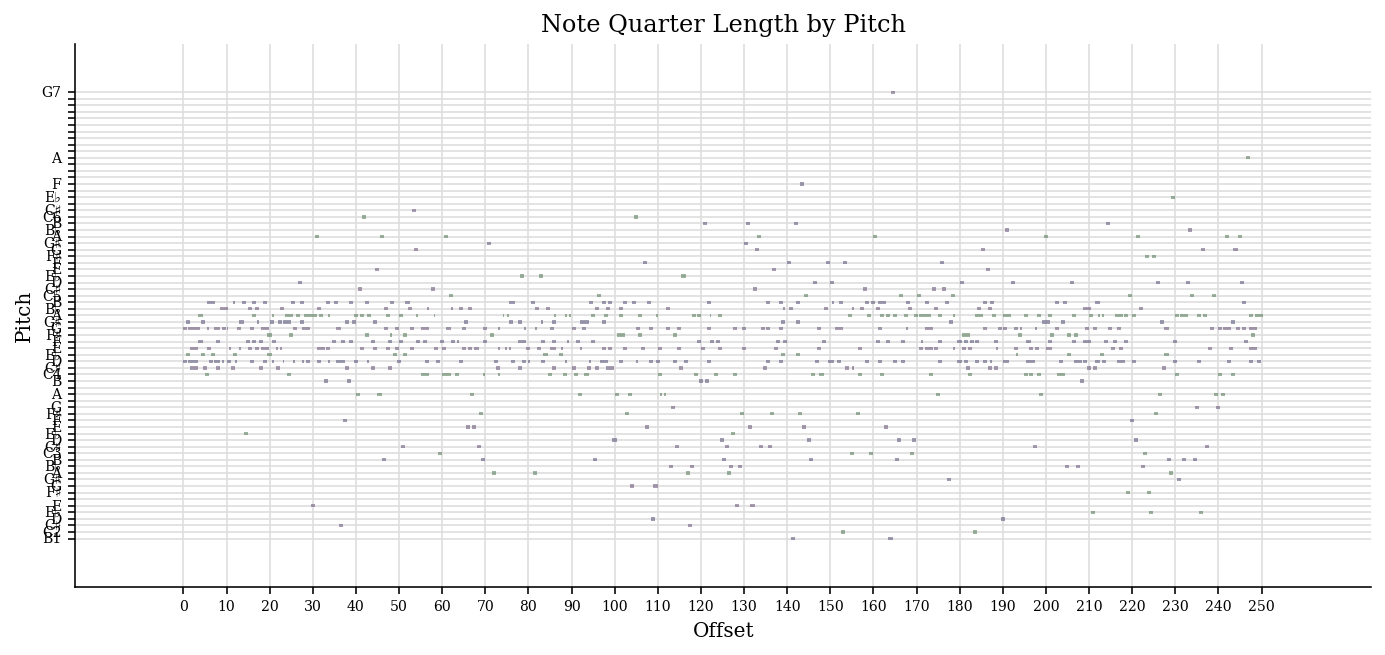

In [ ]:
s = converter.parse('/content/gdrive/MyDrive/VGMIDI/CNNa3.mid')
s.plot('pianoroll', figureSize=(12, 5))

In [ ]:
notes = []

for file in glob.glob("/content/gdrive/My Drive/VGMIDI/Train/*.mid"):
    midi = converter.parse(file)

    notes_to_parse = None

    try: # file has instrument parts
      s2 = instrument.partitionByInstrument(midi)
      notes_to_parse = s2.parts[0].recurse() 
    except: # file has notes in a flat structure
      notes_to_parse = midi.flat.notes

    for element in notes_to_parse:
      if isinstance(element, note.Note):
        notes.append(str(element.pitch))
      elif isinstance(element, chord.Chord):
        notes.append('.'.join(str(n) for n in element.normalOrder))

In [ ]:
n_vocab=len(set(notes))
pitchnames=sorted(set(notes))

In [ ]:
notes2 = []

midi = converter.parse('/content/gdrive/MyDrive/VGMIDI/Test/Donkey_Kong_Country_2_SnakeyChantey.mid')

notes_to_parse = None

try: # file has instrument parts
    s2 = instrument.partitionByInstrument(midi)
    notes_to_parse = s2.parts[0].recurse() 
except: # file has notes in a flat structure
    notes_to_parse = midi.flat.notes

for element in notes_to_parse:
    if isinstance(element, note.Note):
        notes2.append(str(element.pitch))
    elif isinstance(element, chord.Chord):
        notes2.append('.'.join(str(n) for n in element.normalOrder))

print(notes2)
print(len(notes2))

['F5', 'E5', 'D5', 'B-3', 'C5', 'D5', 'F4', 'E5', 'F5', 'C4', 'E5', 'D5', 'G4', 'E5', 'F5', 'F3', 'A5', 'C4', 'F5', 'F3', 'F5', 'C4', 'E5', 'D5', 'B-3', 'C5', 'D5', 'F4', 'E5', 'F5', 'C4', 'E5', 'D5', 'G4', 'E5', 'F5', 'F3', 'C4', 'F3', 'C6', 'B-5', 'A5', 'F3', 'A5', 'C4', 'G5', 'A5', 'F3', 'A5', 'C4', 'G5', 'A5', 'F3', 'G5', 'A5', 'C4', 'B-5', 'C6', 'F3', 'A5', 'C4', 'F5', 'B-3', 'F5', 'F4', 'E5', 'F5', 'B-3', 'F5', 'F4', 'E5', 'F5', 'B-3', 'E5', 'F5', 'F4', 'G5', 'A5', 'B-3', 'F5', 'F4', 'G5', 'A5', 'F3', 'A5', 'C4', 'G5', 'A5', 'F3', 'A5', 'C4', 'G5', 'A5', 'F3', 'G5', 'A5', 'C4', 'B-5', 'C6', 'F3', 'B-5', 'A5', 'C4', 'G5', 'F5', 'B-3', 'E5', 'F5', 'F4', 'G5', 'A5', 'C4', 'G5', 'F5', 'G4', 'E5', 'F5', 'F3', 'A5', 'C4', 'F5', 'F3', 'F5', 'C4', 'E5', 'D5', 'B-3', 'C5', 'D5', 'F4', 'E5', 'F5', 'C4', 'E5', 'D5', 'G4', 'E5', 'F5', 'F3', 'A5', 'C4', 'F5', 'F3', 'C4', 'B-3', 'C4', 'B-3', 'C4', 'B-3', 'C4', 'A3', 'G5', 'F5', 'A5', 'F2', 'A5', 'F2', 'G5', 'A5', 'F2', 'A5', 'F2', 'G5', 'A5', 

In [ ]:
sequence_length = 100

notes_to_int = dict([(note, number) for number, note in enumerate(pitchnames)])

network_input = []
output = []

for i in range(0, len(notes2)- sequence_length):
  sequence_in = notes2[i : i+sequence_length]
  sequence_out = notes2[i+sequence_length]
  network_input.append([notes_to_int[char] for char in sequence_in])
  output.append(notes_to_int[sequence_out])

print(network_input)

[[22, 17, 14, 4, 11, 14, 21, 17, 22, 10, 17, 14, 25, 17, 22, 20, 2, 10, 22, 20, 22, 10, 17, 14, 4, 11, 14, 21, 17, 22, 10, 17, 14, 25, 17, 22, 20, 10, 20, 12, 5, 2, 20, 2, 10, 26, 2, 20, 2, 10, 26, 2, 20, 26, 2, 10, 5, 12, 20, 2, 10, 22, 4, 22, 21, 17, 22, 4, 22, 21, 17, 22, 4, 17, 22, 21, 26, 2, 4, 22, 21, 26, 2, 20, 2, 10, 26, 2, 20, 2, 10, 26, 2, 20, 26, 2, 10, 5, 12, 20], [17, 14, 4, 11, 14, 21, 17, 22, 10, 17, 14, 25, 17, 22, 20, 2, 10, 22, 20, 22, 10, 17, 14, 4, 11, 14, 21, 17, 22, 10, 17, 14, 25, 17, 22, 20, 10, 20, 12, 5, 2, 20, 2, 10, 26, 2, 20, 2, 10, 26, 2, 20, 26, 2, 10, 5, 12, 20, 2, 10, 22, 4, 22, 21, 17, 22, 4, 22, 21, 17, 22, 4, 17, 22, 21, 26, 2, 4, 22, 21, 26, 2, 20, 2, 10, 26, 2, 20, 2, 10, 26, 2, 20, 26, 2, 10, 5, 12, 20, 5], [14, 4, 11, 14, 21, 17, 22, 10, 17, 14, 25, 17, 22, 20, 2, 10, 22, 20, 22, 10, 17, 14, 4, 11, 14, 21, 17, 22, 10, 17, 14, 25, 17, 22, 20, 10, 20, 12, 5, 2, 20, 2, 10, 26, 2, 20, 2, 10, 26, 2, 20, 26, 2, 10, 5, 12, 20, 2, 10, 22, 4, 22, 21, 17, 

In [ ]:
from keras.models import load_model

model = load_model('/content/gdrive/My Drive/VGMIDI/Data/CNN_modelc')
int_to_note = dict([(number, note) for number, note in enumerate(pitchnames)])

#start = numpy.random.randint(0, len(network_input)-1)
start=0
pattern = network_input[start]
prediction_output = []

  # generate 500 notes 
for note_index in range(500):
  prediction_input = numpy.reshape(pattern, (1, len(pattern), 1))
  prediction_input = prediction_input/float(n_vocab)

  prediction = model.predict(prediction_input)

  index = numpy.argmax(prediction)
  result = int_to_note[index]
  prediction_output.append(result)

  pattern.append(index)
  pattern = pattern[1:len(pattern)]


KeyError: ignored

In [ ]:
import numpy

def prepare_sequences(notes):
  sequence_length = 100

  pitchnames=sorted(set(notes))

  notes_to_int = dict([(note, number) for number, note in enumerate(pitchnames)])

  network_input = []
  output = []

  for i in range(0, len(notes)- sequence_length):
    sequence_in = notes[i : i+sequence_length]
    sequence_out = notes[i+sequence_length]
    network_input.append([notes_to_int[char] for char in sequence_in])
    output.append(notes_to_int[sequence_out])
  
  return network_input 

In [ ]:
import numpy 
from keras.models import load_model

def generate_note(model_filePath, network_input, pitchnames, n_vocab):
  model = load_model(model_filePath)

  int_to_note = dict([(number, note) for number, note in enumerate(pitchnames)])

  start = numpy.random.randint(0, len(network_input)-1)
  pattern = network_input[start]
  prediction_output = []

  # generate 500 notes 
  for note_index in range(500):
    prediction_input = numpy.reshape(pattern, (1, len(pattern), 1))
    prediction_input = prediction_input/float(n_vocab)

    prediction = model.predict(prediction_input)

    index = numpy.argmax(prediction)
    result = int_to_note[index]
    prediction_output.append(result)

    pattern.append(index)
    pattern = pattern[1:len(pattern)]

  return prediction_output 

In [ ]:

def create_midi(prediction_output):
    """ convert the output from the prediction to notes and create a midi file
        from the notes """
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for pattern in prediction_output:
        # pattern is a chord
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                new_note = note.Note(int(current_note))
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
        # pattern is a note
        else:
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)

        # increase offset each iteration so that notes do not stack
        offset += 0.5

    midi_stream = stream.Stream(output_notes)

    midi_stream.write('midi', fp='test_output.mid')

In [ ]:


def generate():
  with open('/content/gdrive/My Drive/VGMIDI/Data/notes', 'rb') as filepath:
    notes = pickle.load(filepath)
  
  n_vocab = len(set(notes))
  pitchnames=sorted(set(notes))

  network_input = prepare_sequences(notes) 
  prediction_output = generate_note('/content/gdrive/My Drive/VGMIDI/Data/LSTM_model', network_input, pitchnames, n_vocab)
  create_midi(prediction_output)

  return 

generate()

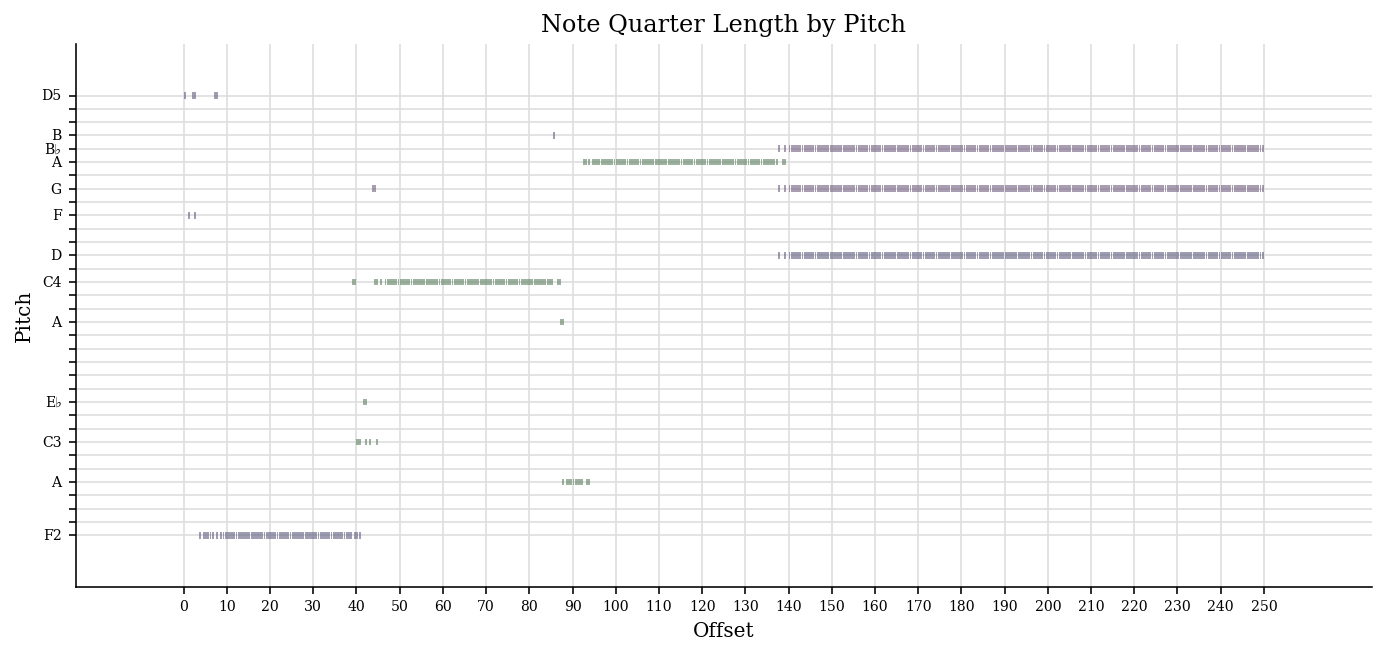

In [ ]:
s = converter.parse('/content/test_output.mid')
s.plot('pianoroll', figureSize=(12, 5))

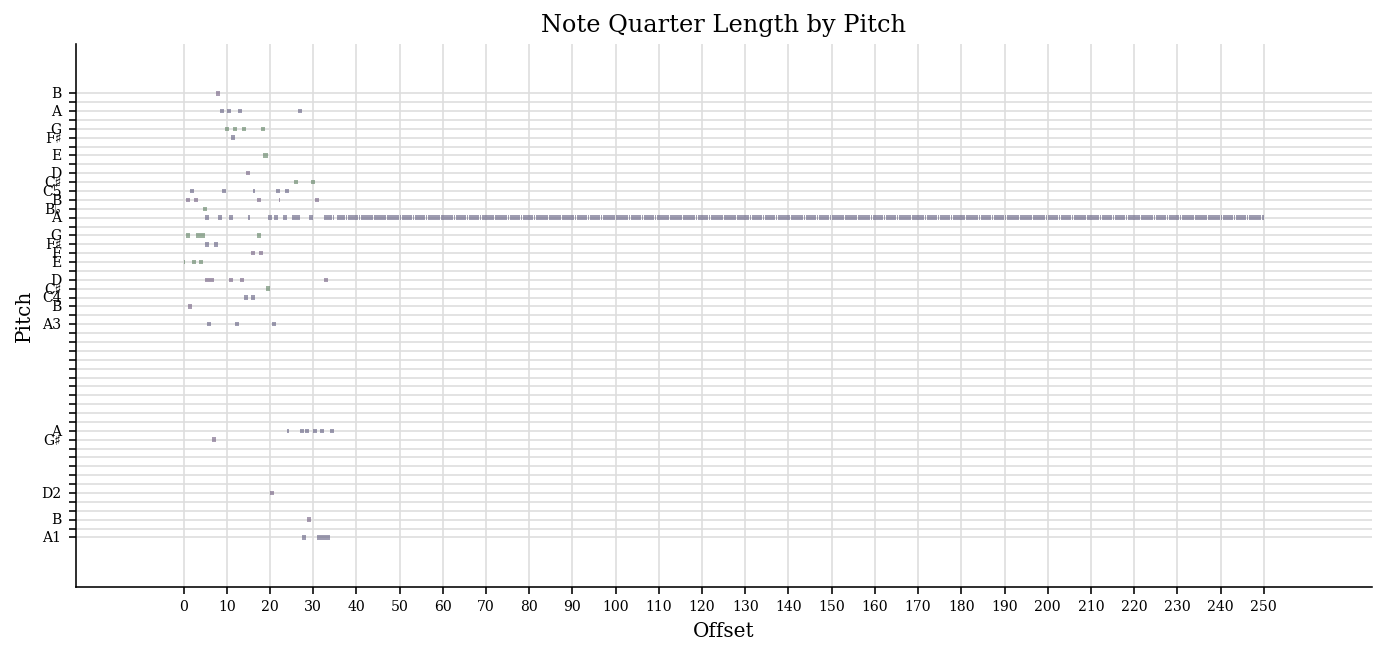

In [ ]:
s = converter.parse('/content/gdrive/My Drive/VGMIDI/Data/CNNa1.mid')
s.plot('pianoroll', figureSize=(12, 5))

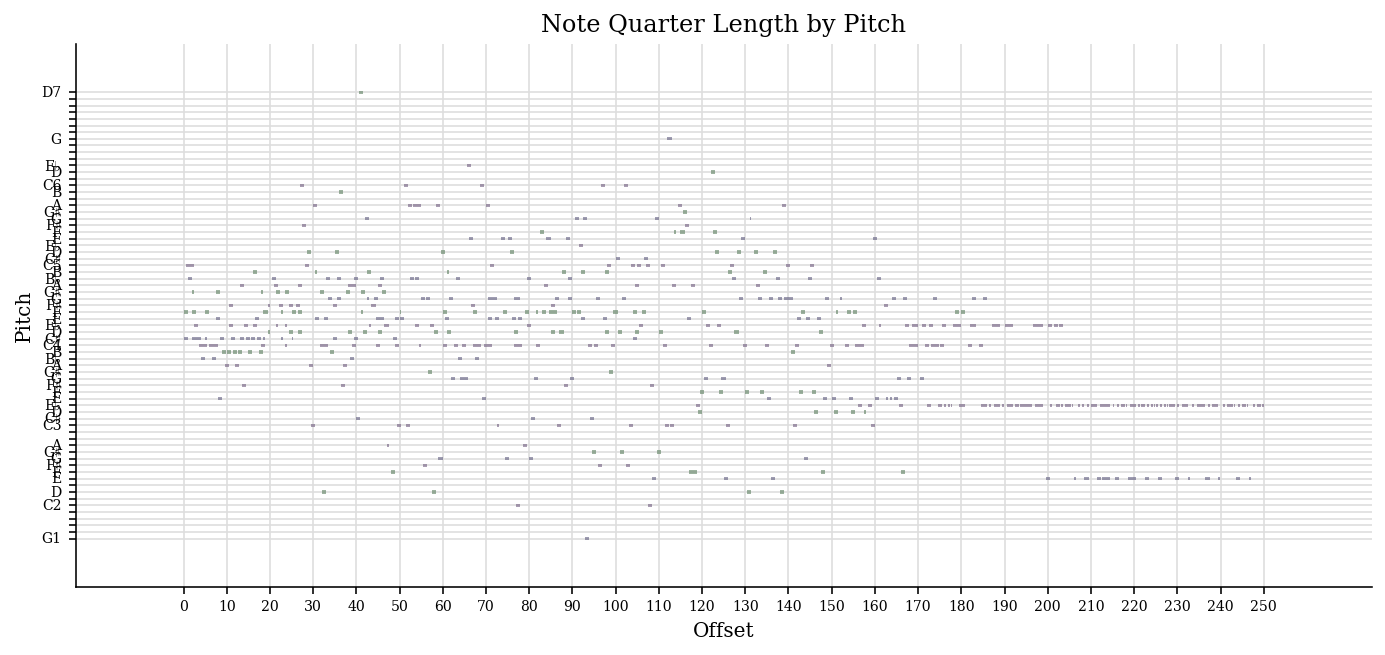

In [ ]:
s = converter.parse('/content/gdrive/My Drive/VGMIDI/Data/CNNa2.mid')
s.plot('pianoroll', figureSize=(12, 5))

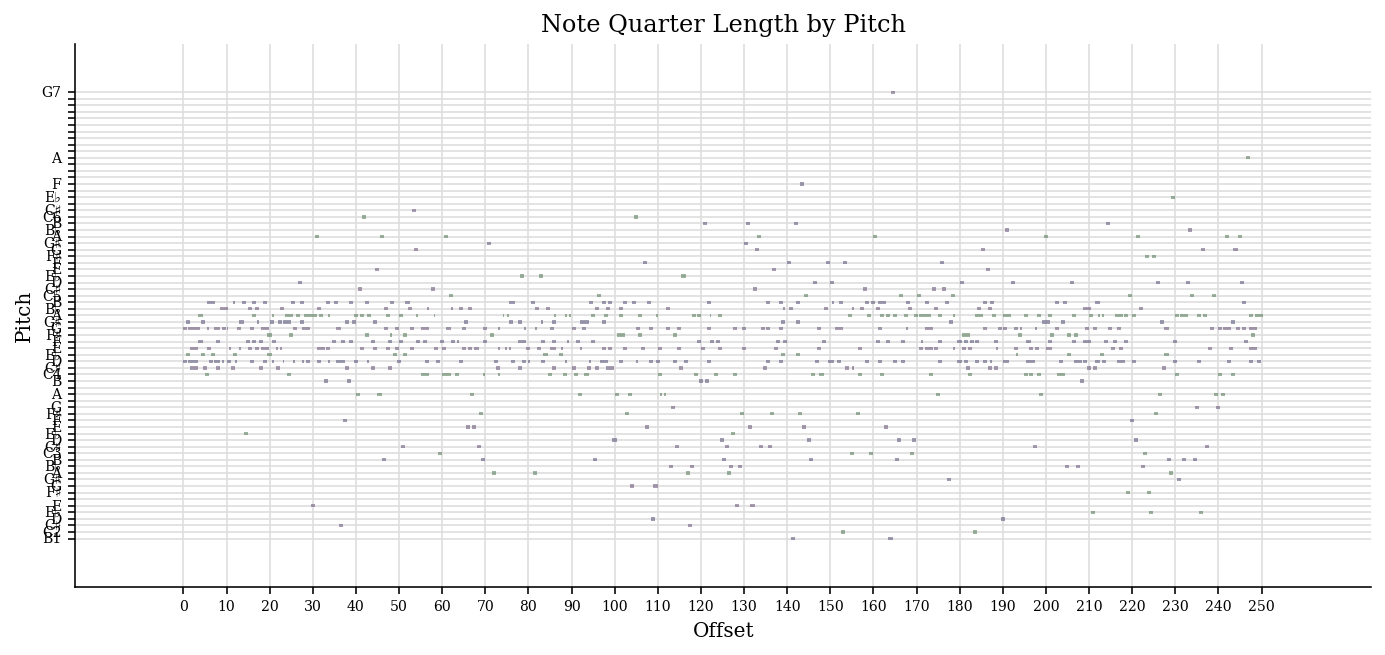

In [ ]:
s = converter.parse('/content/test_output.mid')
s.plot('pianoroll', figureSize=(12, 5))